<a href="https://colab.research.google.com/github/joyjeni/ComputerVision/blob/main/sam_extract_sclera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# Mount Google Drive.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/MyDrive/PhD/sam_scleranet/')

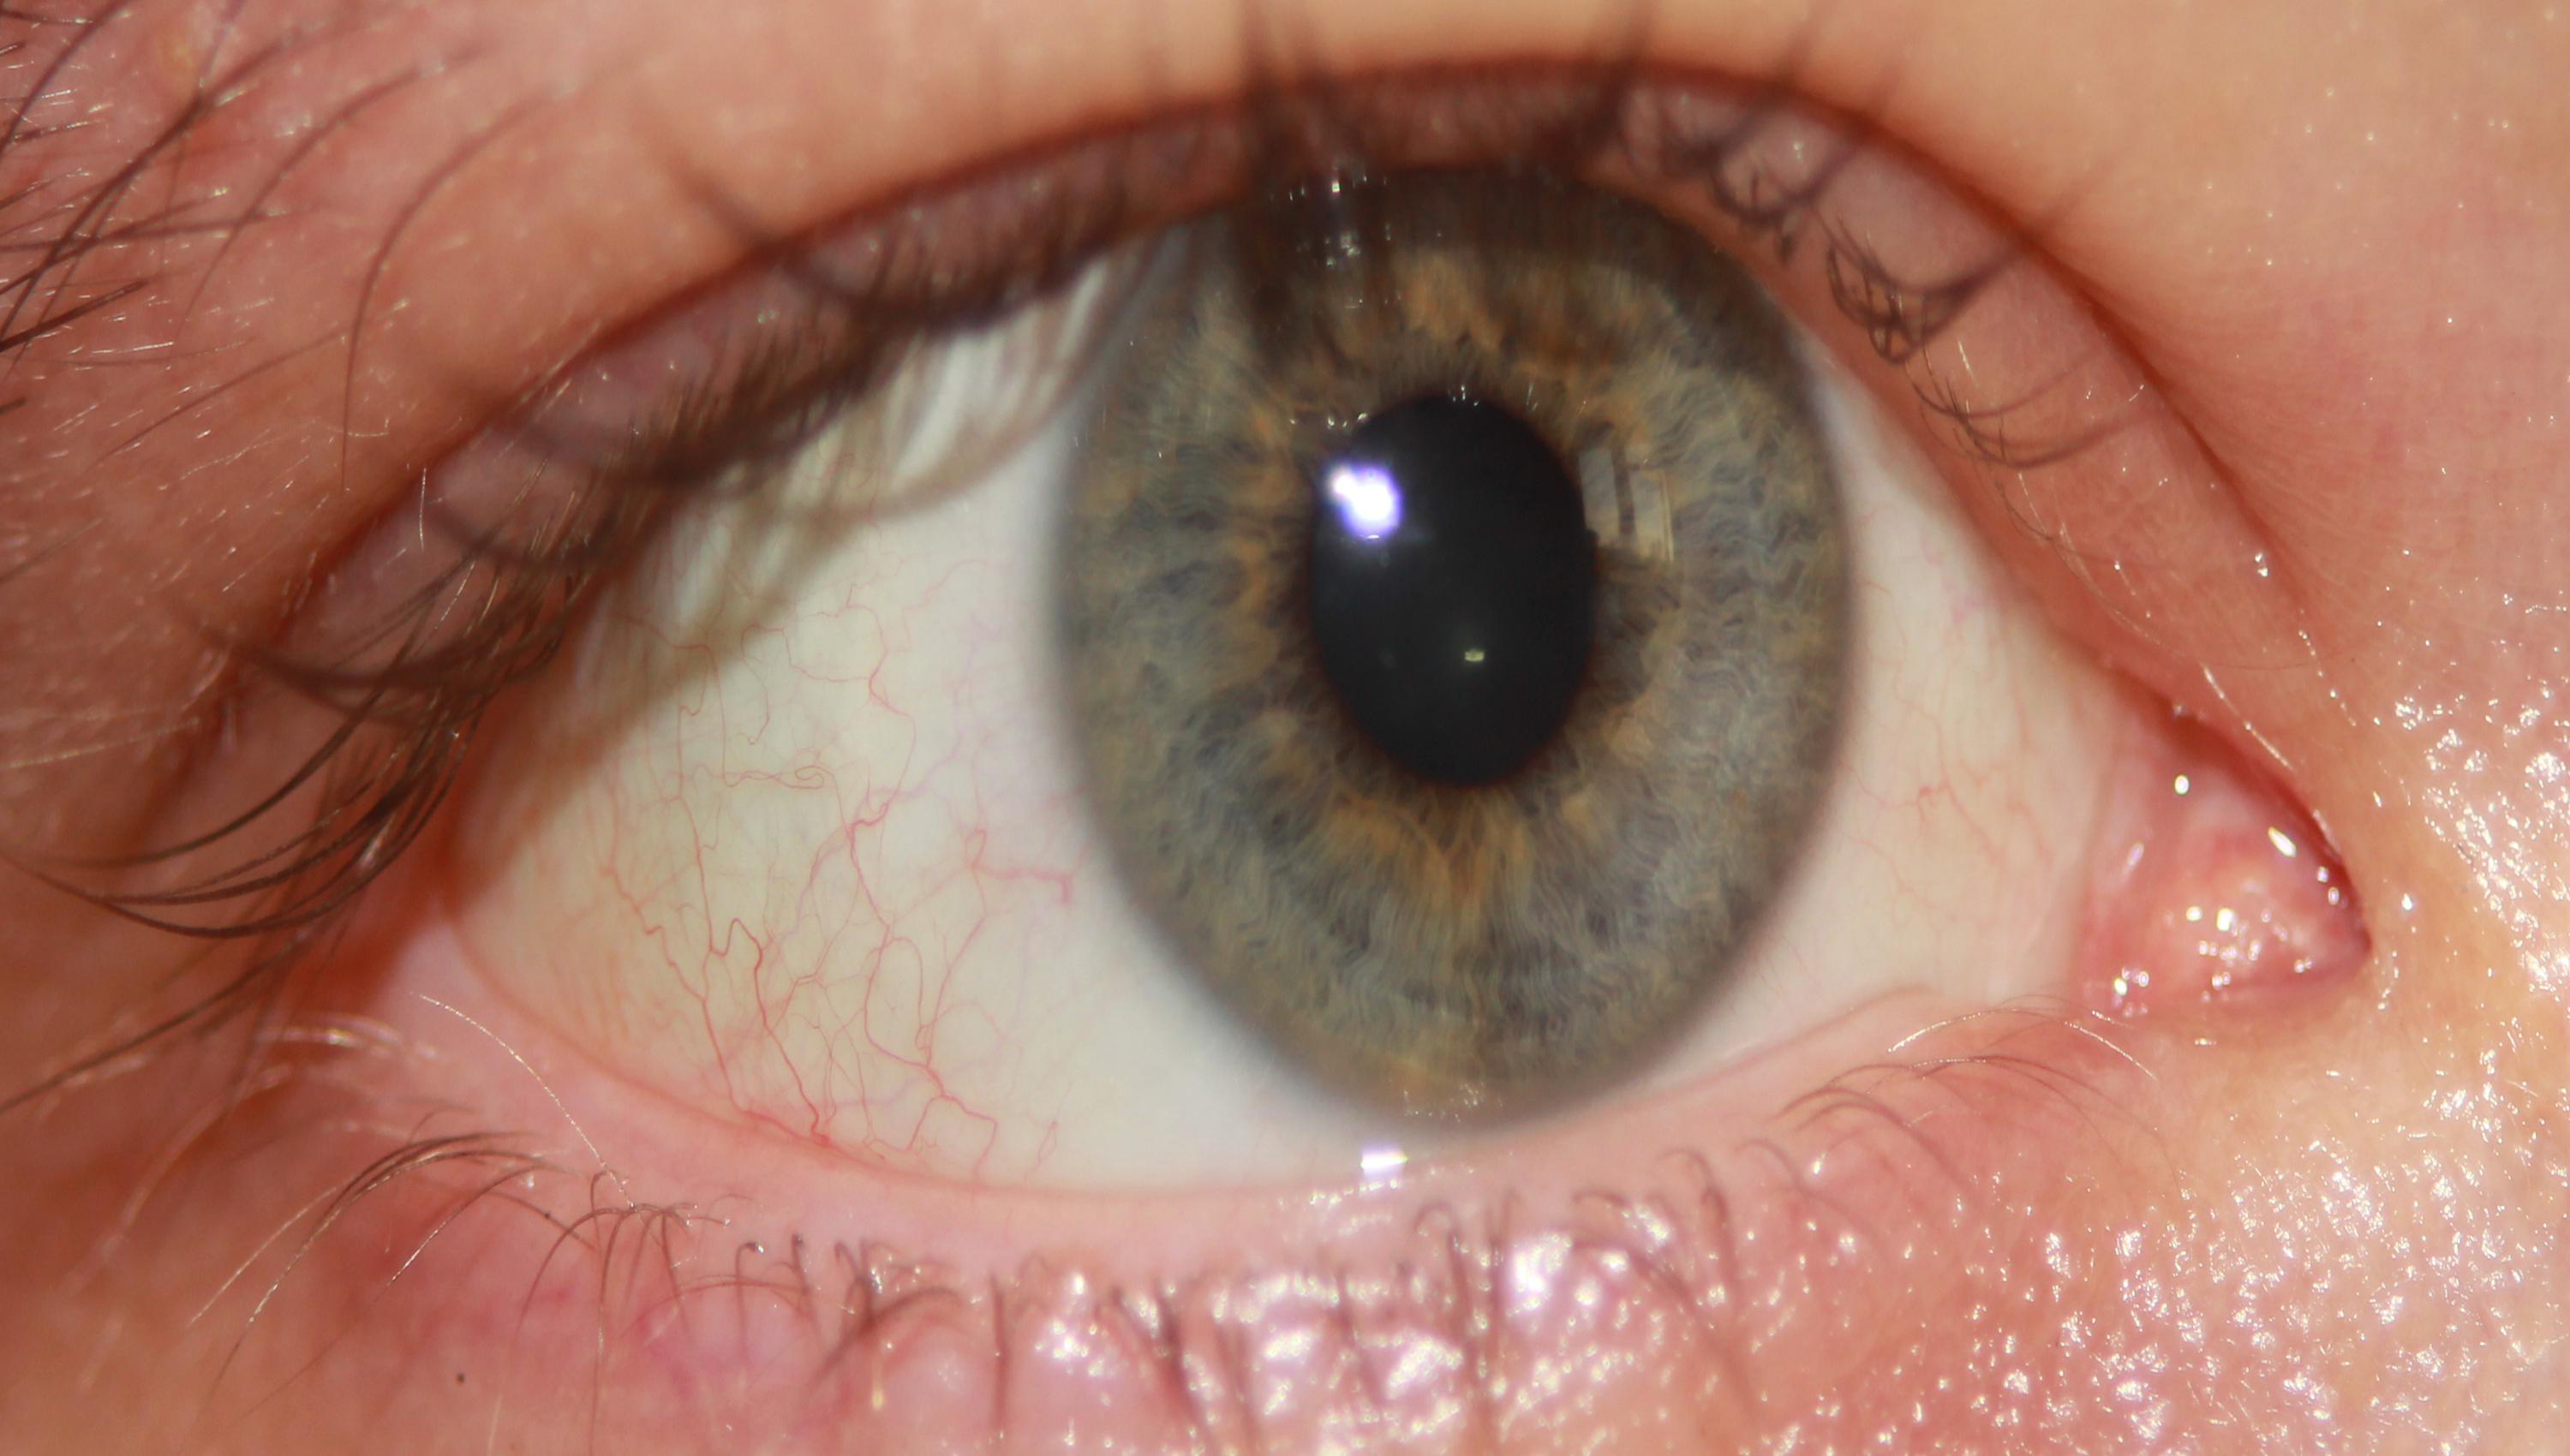

In [3]:
import PIL.Image

# Import the image.
image = PIL.Image.open('/content/drive/MyDrive/PhD/sam_scleranet/images/55L_s_2.jpg')

# Resize the image to its original size.
image = image.resize((image.width, image.height))

# Display the image.
image.show()




In [4]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-wf5rs3j2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-wf5rs3j2
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=dd4656f76f1acebfefb1893e5c5e23adb9789b2883cbb157778b6f21f63dcd8f
  Stored in directory: /tmp/pip-ephem-wheel-cache-6awc4ec3/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [5]:
import torch
import os
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt
import matplotlib

In [6]:
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.7 MB/s eta 0:00:00


In [7]:
using_colab = True

In [8]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-5zb_zbpt
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-5zb_zbpt
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
mkdir: cannot create directory ‘images’: File exists
--2023-07-26 04:45:24--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271475 (265K) [image/jpeg]
Saving to: ‘images/truck.jpg.6

In [9]:
# define model, checkpoint and input image
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_ABS_PATH = r"./checkpoint/sam_vit_h_4b8939.pth"

In [10]:
IMAGE_PATH = r"'./images/55L_s_2.jpg'"

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [12]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

## Example Image

In [13]:
image = cv2.imread('images/55L_s_2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

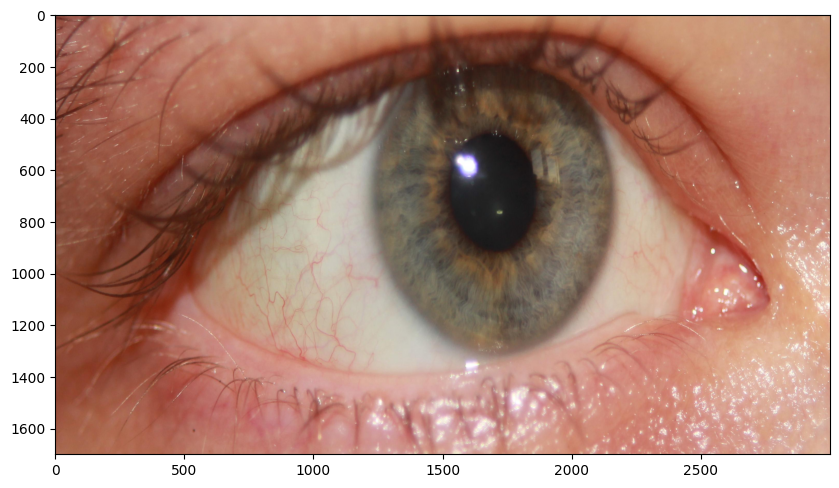

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

### Selecting objects with SAM

In [15]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "checkpoint/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [16]:
predictor.set_image(image)

In [17]:
input_point = np.array([[1200, 800]])
input_label = np.array([1])

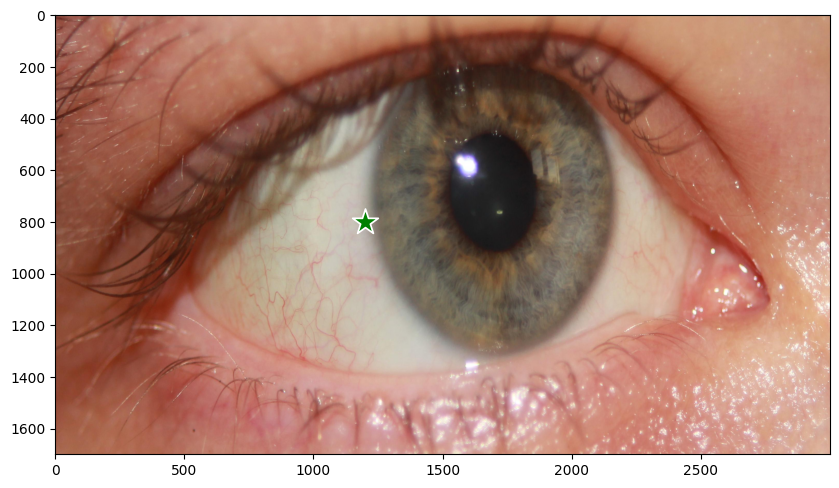

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [19]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [20]:
masks.shape  # (number_of_masks) x H x W

(3, 1700, 3000)

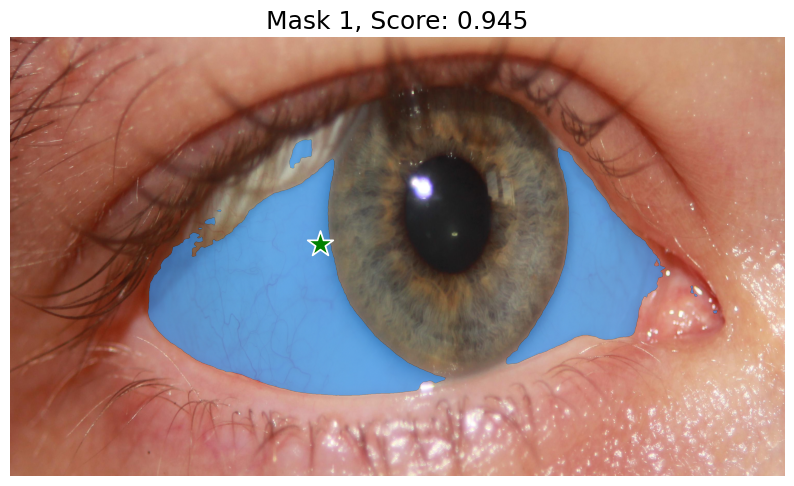

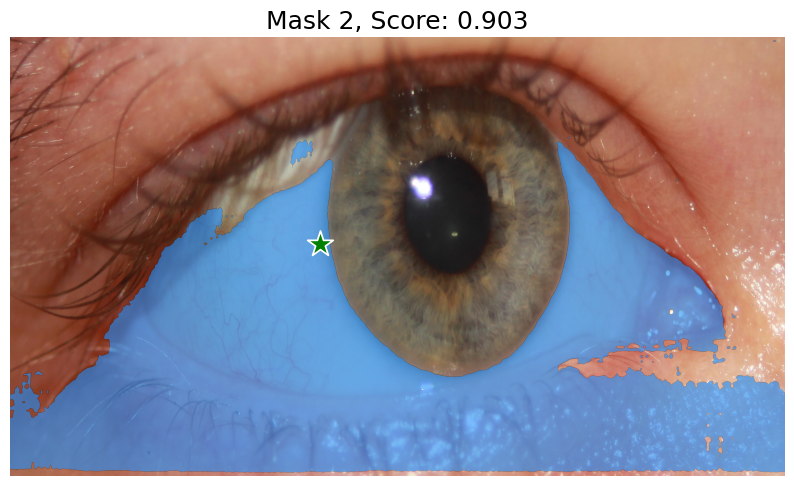

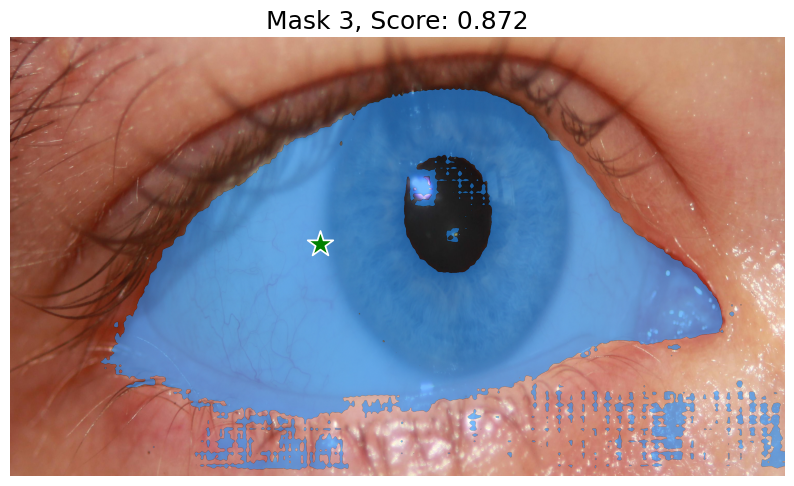

In [21]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

### Specifying a specific object with additional points

In [22]:
input_point = np.array([[1200, 800], [1100, 410],[1000,600],[2400,1500],[2500,1600],[300,300],[2000,1300]])
input_label = np.array([1, 1,1,0,0,0,0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [23]:

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

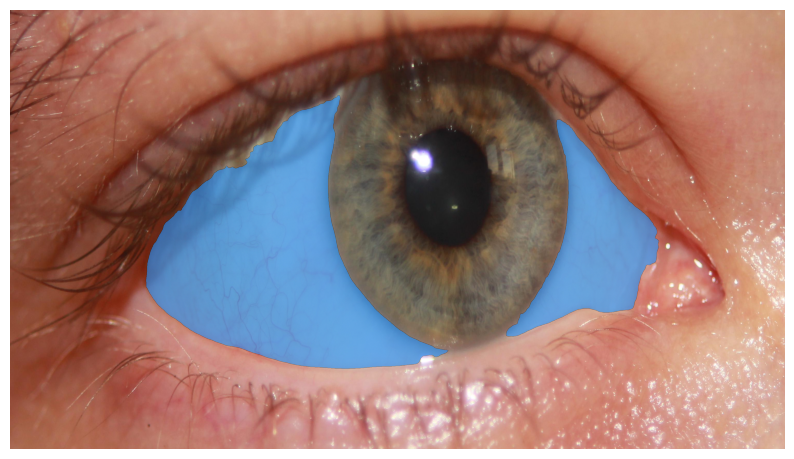

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
#show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

In [25]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

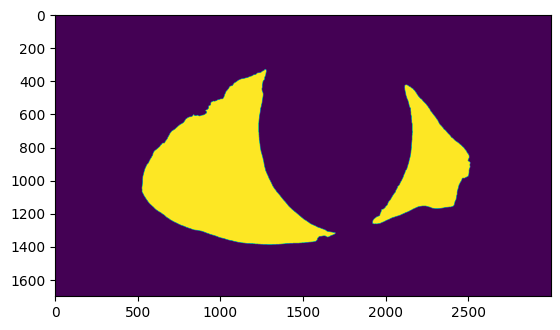

In [26]:

# Get the masked image
masked_image = masks[0]
# Plot the cut image
plt.imshow(masked_image)
plt.show()


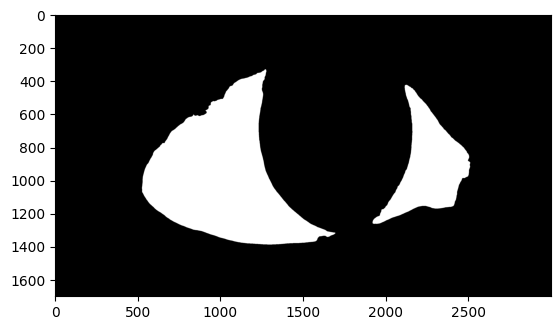

In [27]:
plt.imshow(masked_image, cmap='gray')


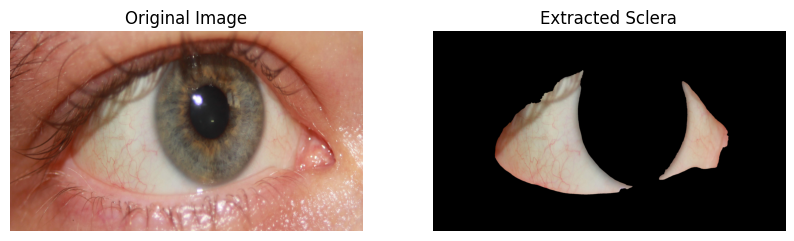

In [28]:
current_mask = masks[0]
# apply the mask: we multiply the image with the mask to keep parts of the image
masked_image = np.where(current_mask[:,:,None], image, 0)

# combine the current masked image with the final masked image using logical or
#final_masked_image = np.maximum(final_masked_#image, masked_image)

# plot the original image and the final masked image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow((masked_image))
plt.title('Extracted Sclera')
plt.axis('off')

plt.show()


In [29]:
def save_masked_image(masked_image, path):
  """Saves the masked image in gray scale.

  Args:
    masked_image: The masked image.
    path: The path to the image file.
  """

  masked_image = masked_image[:, :, 0]
  masked_image = masked_image.astype(np.uint8)

  image = PIL.Image.fromarray(masked_image)
  image.save(path)


In [30]:

  save_masked_image(masked_image, '/content/drive/MyDrive/PhD/sam_scleranet/images/55L_s_2_sclera_predicted.png')

In [31]:
import numpy as np
import cv2
import PIL.Image

def read_true_mask(mask_path):
  """Reads a true mask from a PNG file.

  Args:
    mask_path: The path to the PNG file.

  Returns:
    A NumPy array of the mask.
  """

  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
  mask = mask > 127
  mask = mask.astype(np.float32)
  mask = mask[..., np.newaxis]

  return mask

def calculate_precision_recall_f1(true_mask, predicted_mask):
  """Calculates the precision, recall, and F1 score.

  Args:
    true_mask: The ground truth mask.
    predicted_mask: The predicted mask.

  Returns:
    The precision, recall, and F1 score.
  """

  true_positives = np.sum(true_mask * predicted_mask)
  false_positives = np.sum(predicted_mask * (1 - true_mask))
  false_negatives = np.sum(true_mask * (1 - predicted_mask))

  precision = round(true_positives / (true_positives + false_positives),4)
  recall = round(true_positives / (true_positives + false_negatives),4)
  f1 = round(2 * precision * recall / (precision + recall),4)

  return precision, recall, f1

if __name__ == '__main__':
  # Import the image.
  ground_truth = '/content/drive/MyDrive/PhD/sam_scleranet/images/55L_s_2_sclera.png'
  predicted_mask= '/content/drive/MyDrive/PhD/sam_scleranet/images/55L_s_2_sclera_predicted.png'

# Resize the image to its original size.
  #gt_image = ground_truth.resize((image.width, image.height))

  true_mask = read_true_mask(ground_truth)
  predicted_mask = read_true_mask(predicted_mask)

  precision, recall, f1 = calculate_precision_recall_f1(true_mask, predicted_mask)

  print('Precision:', precision)
  print('Recall:', recall)
  print('F1 score:', f1)


Precision: 0.9275
Recall: 0.9313
F1 score: 0.9294
